In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr


In [3]:
import pandas as pd

gold_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/LBM_Gold_Daily_Price_USD-Ounce.xlsx"

gold = pd.read_excel(gold_path)

gold.head()

gold = gold.rename(columns={
    gold.columns[0]: "Date",
    gold.columns[1]: "Gold"
})

gold["Date"] = pd.to_datetime(gold["Date"])
gold = gold.set_index("Date").sort_index()



In [4]:

silver_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/Silver_Daily_Price_USD-Ounce.xlsx"

silver = pd.read_excel(silver_path)

silver = silver.rename(columns={
    silver.columns[0]: "Date",
    silver.columns[1]: "Silver"
})

silver["Date"] = pd.to_datetime(silver["Date"])
silver = silver.set_index("Date").sort_index()


In [5]:
copper_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/Global_Copper_Monthly_Price_USD-MetricTonne.xlsx"

copper = pd.read_excel(copper_path)

copper = copper.rename(columns={
    copper.columns[0]: "Date",
    copper.columns[1]: "Copper"
})

copper["Date"] = pd.to_datetime(copper["Date"])
copper = copper.set_index("Date").sort_index()


In [6]:
prices_daily = gold.join(silver, how="inner")

prices_daily.tail()




,Gold,Silver
Date,,
2025-12-18,4333.35,66.30
2025-12-19,4337.60,65.78
2025-12-22,4421.65,69.22
2025-12-23,4449.40,69.74
2025-12-30,4367.80,74.83


In [7]:
prices_daily.isna().sum()
prices_daily.describe()

,Gold,Silver
count,14470.000000,14470.000000
mean,706.680409,11.076361
std,685.913796,9.264871
min,34.750000,1.270000
25%,290.462500,4.720000
50%,391.000000,6.390000
75%,1194.000000,16.510000
max,4449.400000,74.830000


In [8]:
prices_monthly = prices_daily.resample("ME").last()

prices_monthly.head(5)
prices_monthly.tail(5)


,Gold,Silver
Date,,
2025-08-31,3429.15,38.80
2025-09-30,3825.30,46.17
2025-10-31,4011.50,48.96
2025-11-30,4191.05,53.91
2025-12-31,4367.80,74.83


<Axes: title={'center': 'Gold–Silver Ratio (Monthly)'}, xlabel='Date'>

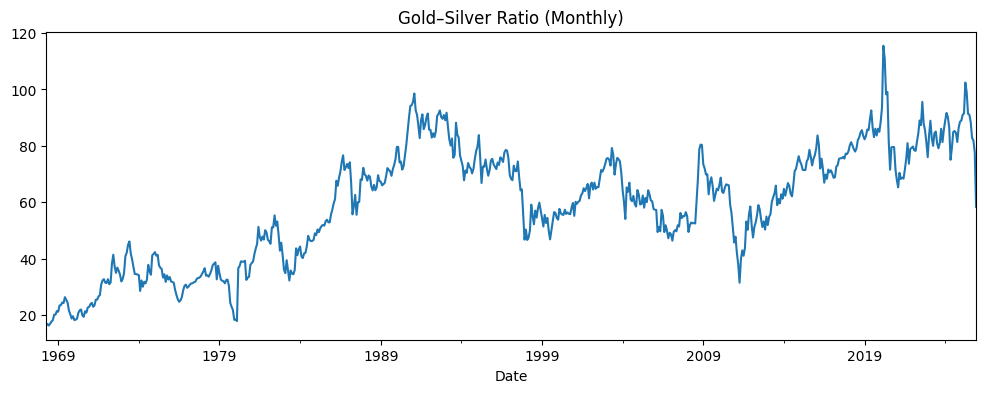

In [9]:
prices_monthly["GS_Ratio"] = prices_monthly["Gold"] / prices_monthly["Silver"]
prices_monthly["GS_Ratio"].plot(
    figsize=(12,4),
    title="Gold–Silver Ratio (Monthly)"
)



In [10]:
prices_monthly


,Gold,Silver,GS_Ratio
Date,,,
1968-04-30,39.10,2.40,16.291667
1968-05-31,41.95,2.48,16.915323
1968-06-30,40.90,2.50,16.360000
1968-07-31,38.85,2.29,16.965066
1968-08-31,39.80,2.24,17.767857
...,...,...,...
2025-08-31,3429.15,38.80,88.380155
2025-09-30,3825.30,46.17,82.852502
2025-10-31,4011.50,48.96,81.934232


In [11]:
ratio = prices_monthly["GS_Ratio"]

ratio_mean = ratio.mean()
ratio_std = ratio.std()
ratio_median = ratio.median()

ratio_mean, ratio_median, ratio_std


(np.float64(59.15882263210348), 61.29770992366413, 20.25801856383583)

In [12]:
prices_monthly["GS_Z"] = (ratio - ratio_mean) / ratio_std


In [13]:
def classify_regime(z):
    if z >= 1.5:
        return "Extreme High (Silver Undervalued)"
    elif z >= 0.75:
        return "High"
    elif z <= -1.0:
        return "Extreme Low (Silver Overheated)"
    elif z <= -0.5:
        return "Low"
    else:
        return "Neutral"

prices_monthly["Regime"] = prices_monthly["GS_Z"].apply(classify_regime)


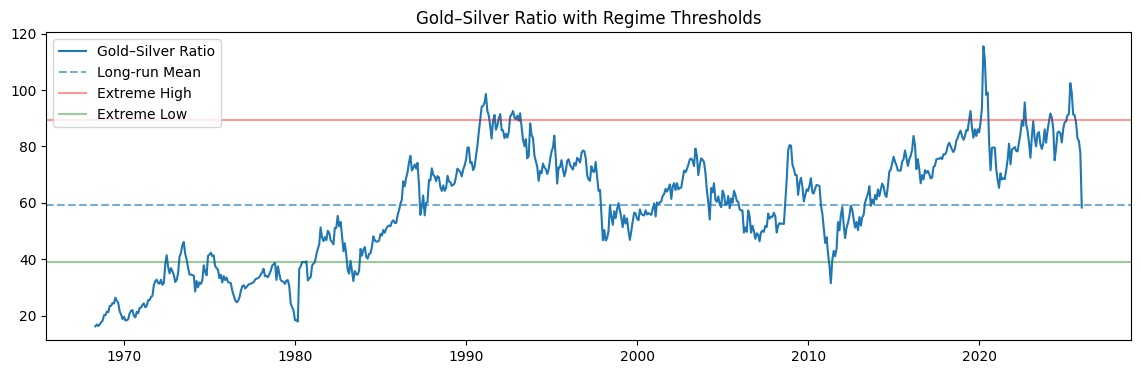

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(prices_monthly.index, prices_monthly["GS_Ratio"], label="Gold–Silver Ratio")

plt.axhline(ratio_mean, linestyle="--", alpha=0.6, label="Long-run Mean")
plt.axhline(ratio_mean + 1.5*ratio_std, color="red", alpha=0.4, label="Extreme High")
plt.axhline(ratio_mean - 1.0*ratio_std, color="green", alpha=0.4, label="Extreme Low")

plt.legend()
plt.title("Gold–Silver Ratio with Regime Thresholds")
plt.show()


In [15]:
regime_distribution = prices_monthly["Regime"].value_counts(normalize=True) * 100
regime_distribution


,proportion
Regime,
Neutral,43.722944
Extreme Low (Silver Overheated),21.356421
High,21.212121
Low,9.090909
Extreme High (Silver Undervalued),4.617605


In [16]:
prices_monthly["Silver_3m_Fwd"] = prices_monthly["Silver"].pct_change(3).shift(-3)
prices_monthly["Silver_6m_Fwd"] = prices_monthly["Silver"].pct_change(6).shift(-6)


In [17]:
forward_perf = prices_monthly.groupby("Regime")[[
    "Silver_3m_Fwd",
    "Silver_6m_Fwd"
]].mean() * 100

forward_perf


,Silver_3m_Fwd,Silver_6m_Fwd
Regime,,
Extreme High (Silver Undervalued),13.214731,24.546902
Extreme Low (Silver Overheated),4.077462,9.019123
High,3.467197,5.499167
Low,0.174259,-0.848490
Neutral,1.050925,3.068641


In [18]:
hit_rates = prices_monthly.groupby("Regime")[[
    "Silver_3m_Fwd",
    "Silver_6m_Fwd"
]].apply(lambda x: (x > 0).mean() * 100)

hit_rates


,Silver_3m_Fwd,Silver_6m_Fwd
Regime,,
Extreme High (Silver Undervalued),78.125000,84.375000
Extreme Low (Silver Overheated),52.702703,51.351351
High,53.741497,58.503401
Low,47.619048,36.507937
Neutral,46.864686,45.874587


In [19]:
current_ratio = prices_monthly["GS_Ratio"].iloc[-1]
current_z = prices_monthly["GS_Z"].iloc[-1]
current_regime = prices_monthly["Regime"].iloc[-1]

current_ratio, current_z, current_regime


(np.float64(58.36963784578378), np.float64(-0.038956662214168214), 'Neutral')

Current regime snapshot

Gold–Silver Ratio: ~58.4

Z-score: ~ –0.04

Regime: Neutral

We are almost exactly at the long-run mean of the ratio.

This is not a stressed regime, not a dislocation, and not an asymmetric opportunity.

In [20]:
regime_data = prices_monthly[
    prices_monthly["Regime"] == current_regime
]


In [21]:
quantiles_6m = regime_data["Silver_6m_Fwd"].quantile(
    [0.10, 0.25, 0.50, 0.75, 0.90]
) * 100

quantiles_6m


,Silver_6m_Fwd
0.10,-15.366094
0.25,-8.594429
0.50,-2.037353
0.75,9.026043
0.90,28.758295


Median outcome is slightly negative

Upside exists, but:

It is skew-driven, not typical

Requires favorable macro tailwinds

Downside is material and more probable than upside

In [22]:
current_silver = prices_monthly["Silver"].iloc[-1]
current_silver


np.float64(74.83)

In [23]:
price_ranges_6m = current_silver * (1 + quantiles_6m / 100)
price_ranges_6m


,Silver_6m_Fwd
0.10,63.331552
0.25,68.398789
0.50,73.305449
0.75,81.584188
0.90,96.349832


> Most likely outcome: silver stays range-bound

Downside risk: mid-60s is very plausible

Upside > $90: possible, but low probability (~10%)



Neutral regime hit rate ~46%

That means:

>Silver is more likely to be flat or down than meaningfully up



**Silver Outlook (6-Month Horizon)**


> The gold–silver ratio currently trades near its long-run mean, placing silver in a neutral regime historically associated with limited directional edge. Conditional on similar past environments, median six-month silver returns have been slightly negative, with downside outcomes reaching the mid-teens, while upside beyond the $90 level has occurred only in the upper decile of observations.

> In contrast to prior extreme undervaluation regimes—which exhibited both high hit rates and strong average returns—the current regime offers asymmetric risk without commensurate expected return. We therefore view further silver upside as increasingly dependent on exogenous macro catalysts rather than ratio-driven mean reversion.

# **Pseudo Out-Of-Sample Validation**

If we had stopped our data at 31 May 2025 and applied the same framework, would it have told us the same thing about silver?

### Assumptions
Freeze data as of 31 May 2025

Recompute:

* Long-run mean

* Std dev

* Z-scores

* Regimes

* Identify the regime as of May 2025

* Compute forward 6-month outcomes AFTER May 2025

Compare:

* Expected ranges (ex-ante)

* Realised outcomes (ex-post)


In [24]:
cutoff_date = "2025-05-31"

prices_trunc = prices_monthly.loc[:cutoff_date].copy()
prices_trunc.tail()


,Gold,Silver,GS_Ratio,GS_Z,Regime,Silver_3m_Fwd,Silver_6m_Fwd
Date,,,,,,,
2025-01-31,2812.05,31.61,88.960772,1.471119,High,0.019614,0.145840
2025-02-28,2834.55,31.14,91.026012,1.573065,Extreme High (Silver Undervalued),0.062299,0.245986
2025-03-31,3115.10,34.05,91.486050,1.595774,Extreme High (Silver Undervalued),0.056681,0.355947
2025-04-30,3302.05,32.23,102.452684,2.137122,Extreme High (Silver Undervalued),0.123798,0.519082
2025-05-31,3277.55,33.08,99.079504,1.970611,Extreme High (Silver Undervalued),0.172914,0.629686


In [25]:
ratio_trunc = prices_trunc["GS_Ratio"]

mean_trunc = ratio_trunc.mean()
std_trunc = ratio_trunc.std()

mean_trunc, std_trunc


(np.float64(58.929065600429226), 20.20390745255241)

In [26]:
prices_trunc["GS_Z"] = (ratio_trunc - mean_trunc) / std_trunc

prices_trunc["Regime"] = prices_trunc["GS_Z"].apply(classify_regime)


In [27]:
prices_trunc[["GS_Ratio", "GS_Z", "Regime"]].tail(6)


,GS_Ratio,GS_Z,Regime
Date,,,
2024-12-31,88.564155,1.466800,High
2025-01-31,88.960772,1.486431,High
2025-02-28,91.026012,1.588650,Extreme High (Silver Undervalued)
2025-03-31,91.486050,1.611420,Extreme High (Silver Undervalued)
2025-04-30,102.452684,2.154218,Extreme High (Silver Undervalued)
2025-05-31,99.079504,1.987261,Extreme High (Silver Undervalued)


In [28]:
regime_may_2025 = prices_trunc["Regime"].iloc[-1]
ratio_may_2025 = prices_trunc["GS_Ratio"].iloc[-1]
z_may_2025 = prices_trunc["GS_Z"].iloc[-1]

ratio_may_2025, z_may_2025, regime_may_2025


(np.float64(99.07950423216447),
 np.float64(1.9872610645255622),
 'Extreme High (Silver Undervalued)')

In [29]:
prices_trunc["Silver_6m_Fwd"] = prices_trunc["Silver"].pct_change(6).shift(-6)

regime_data_trunc = prices_trunc[
    prices_trunc["Regime"] == regime_may_2025
]

quantiles_6m_trunc = regime_data_trunc["Silver_6m_Fwd"].quantile(
    [0.10, 0.25, 0.50, 0.75, 0.90]
) * 100

quantiles_6m_trunc


,Silver_6m_Fwd
0.10,-1.760323
0.25,3.801928
0.50,14.317549
0.75,26.441538
0.90,50.069603


>Silver offers upside optionality, with a median six-month return of ~14%, but outcomes are widely dispersed, downside risk remains non-trivial, and large gains are concentrated in the upper tail of the distribution

In [30]:
silver_may_2025 = prices_monthly.loc["2025-05-31", "Silver"]
silver_nov_2025 = prices_monthly.loc["2025-11-30", "Silver"]

realised_return = (silver_nov_2025 / silver_may_2025 - 1) * 100

silver_may_2025, silver_nov_2025, realised_return


(np.float64(33.08), np.float64(53.91), np.float64(62.968561064087055))

>Generating regime-conditional six-month silver price ranges dynamically as of any chosen evaluation date, using only information available up to that point, thereby avoiding look-ahead bias.

In [31]:
import pandas as pd
as_of_date = "2025-05-31"   # change this anytime
silver_start_price = prices_monthly.loc[as_of_date, "Silver"]
silver_start_price

current_regime = prices_monthly.loc[as_of_date, "Regime"]
current_regime

regime_data = prices_trunc[
    prices_trunc["Regime"] == current_regime
]

quantiles = regime_data["Silver_6m_Fwd"].quantile(
    [0.10, 0.25, 0.50, 0.75, 0.90]
) * 100


table = pd.DataFrame({
    "Percentile": ["10%", "25%", "50% (Median)", "75%", "90%"],
    "Return (%)": quantiles.values.round(2)
})

table["Implied Price ($)"] = (
    silver_start_price * (1 + table["Return (%)"] / 100)
).round(2)

table["Meaning"] = [
    "Downside risk",
    "Weak upside",
    "Typical outcome",
    "Strong rally",
    "Rare tail upside"
]

table.style.format({
    "Return (%)": "{:+.2f}%",
    "Implied Price ($)": "${:.2f}"
})



,Percentile,Return (%),Implied Price ($),Meaning
0,10%,-1.76%,$32.50,Downside risk
1,25%,+3.80%,$34.34,Weak upside
2,50% (Median),+14.32%,$37.82,Typical outcome
3,75%,+26.44%,$41.83,Strong rally
4,90%,+50.07%,$49.64,Rare tail upside


> Based on information available as of 31 May 2025, regime-conditional analysis suggested a median six-month silver price of approximately $38, with downside risk towards the low $30 and upside beyond $50 confined to the upper decile of historical outcomes.

> Silver’s post–May 2025 rally exceeded the 90th percentile of historically expected outcomes for the prevailing ratio regime, indicating a tail-driven move rather than systematic alpha; validating the model while signalling that the asymmetric opportunity has largely passed.



In [32]:
prod_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/Daily_Industrial_Production_Mining_Gold_Ore_Silver_Ore.xlsx"

prod = pd.read_excel(prod_path)
prod.columns = ["Date", "Mining_Production"]

prod["Date"] = pd.to_datetime(prod["Date"])
prod = prod.set_index("Date").sort_index()


In [33]:
prod_monthly = prod.resample("M").mean()


/tmp/ipython-input-1807965734.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prod_monthly = prod.resample("M").mean()


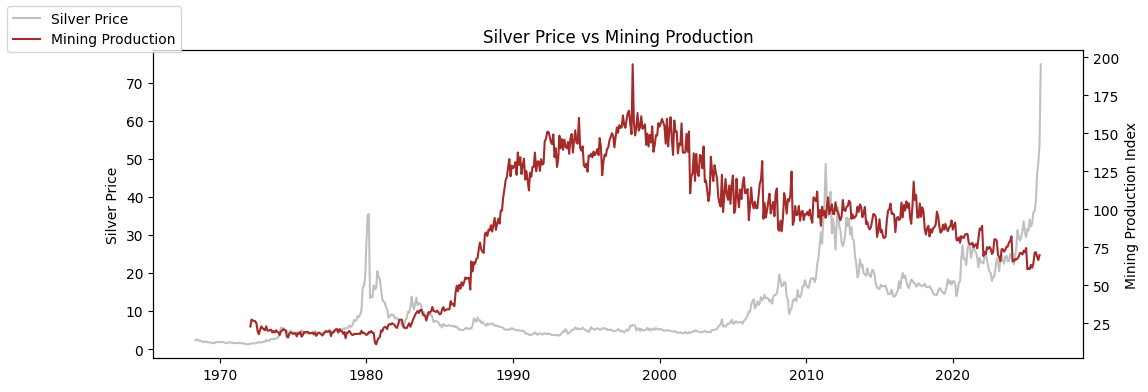

In [34]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(prices_monthly.index, prices_monthly["Silver"], color="silver", label="Silver Price")
ax1.set_ylabel("Silver Price")

ax2 = ax1.twinx()
ax2.plot(prod_monthly.index, prod_monthly["Mining_Production"], color="brown", label="Mining Production")
ax2.set_ylabel("Mining Production Index")

plt.title("Silver Price vs Mining Production")
fig.legend(loc="upper left")
plt.show()


>Silver price movements have historically been driven by macro demand rather than mining supply; the 2025 rally occurred without supply constraint and is best viewed as a demand-led tail event, leaving limited structural support for further upside under current conditions.

In [35]:
prod_monthly["Prod_Change"] = prod_monthly["Mining_Production"].pct_change(6)
prices_monthly["Silver_Change_6m"] = prices_monthly["Silver"].pct_change(6)

merged = prod_monthly.join(prices_monthly["Silver_Change_6m"], how="inner")

merged.corr()


,Mining_Production,Prod_Change,Silver_Change_6m
Mining_Production,1.000000,-0.012527,-0.146099
Prod_Change,-0.012527,1.000000,-0.102932
Silver_Change_6m,-0.146099,-0.102932,1.000000


In [36]:
dxy_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/US_Dollar_Index.xlsx"

dxy = pd.read_excel(dxy_path)
dxy.columns = ["Date", "DXY"]

dxy["Date"] = pd.to_datetime(dxy["Date"])
dxy = dxy.set_index("Date").sort_index()


In [37]:
dxy_monthly = dxy.resample("M").last()


/tmp/ipython-input-1294778120.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dxy_monthly = dxy.resample("M").last()


In [38]:
macro = prices_monthly[["Silver"]].join(dxy_monthly, how="inner")

macro["Silver_Return_6m"] = macro["Silver"].pct_change(6)
macro["DXY_Change_6m"] = macro["DXY"].pct_change(6)

macro[["Silver_Return_6m", "DXY_Change_6m"]].corr()


,Silver_Return_6m,DXY_Change_6m
Silver_Return_6m,1.000000,-0.239365
DXY_Change_6m,-0.239365,1.000000


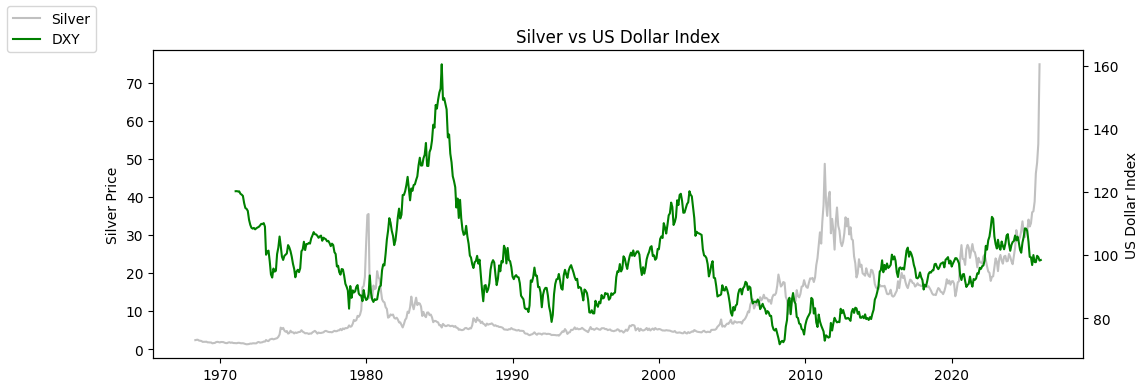

In [39]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(prices_monthly.index, prices_monthly["Silver"], color="silver", label="Silver")
ax1.set_ylabel("Silver Price")

ax2 = ax1.twinx()
ax2.plot(dxy_monthly.index, dxy_monthly["DXY"], color="green", label="DXY")
ax2.set_ylabel("US Dollar Index")

plt.title("Silver vs US Dollar Index")
fig.legend(loc="upper left")
plt.show()


# **COPPER DYNAMICS**

>Among major industrial and precious metals, copper uniquely exhibits forward-looking supply constraints combined with structurally rising demand driven by electrification, grid expansion, and energy transition requirements. Unlike silver, where supply responds reactively and demand is partially macro-cyclical, copper’s long project lead times, declining ore grades, and transparent inventory signals create conditions where structural deficits emerge ahead of price dislocations. This makes copper a more compelling candidate for sustained asymmetric upside relative to other metals.

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

copper_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/Global_Copper_Monthly_Price_USD-MetricTonne.xlsx"

copper = pd.read_excel(copper_path)
copper.columns = ["Date", "Copper"]
copper["Date"] = pd.to_datetime(copper["Date"])
copper = copper.set_index("Date").sort_index()

copper.tail(10)


,Copper
Date,
2025-02-01,9330.980
2025-03-01,9735.820
2025-04-01,9172.700
2025-05-01,9531.200
2025-06-01,9835.070
2025-07-01,9770.580
2025-08-01,9671.876
2025-09-01,9994.773
2025-10-01,10739.920


In [41]:
copper.describe()


,Copper
count,541.000000
mean,4276.768353
std,2823.229252
min,1272.070000
25%,1766.130000
50%,2859.390000
75%,6891.130000
max,10812.030000


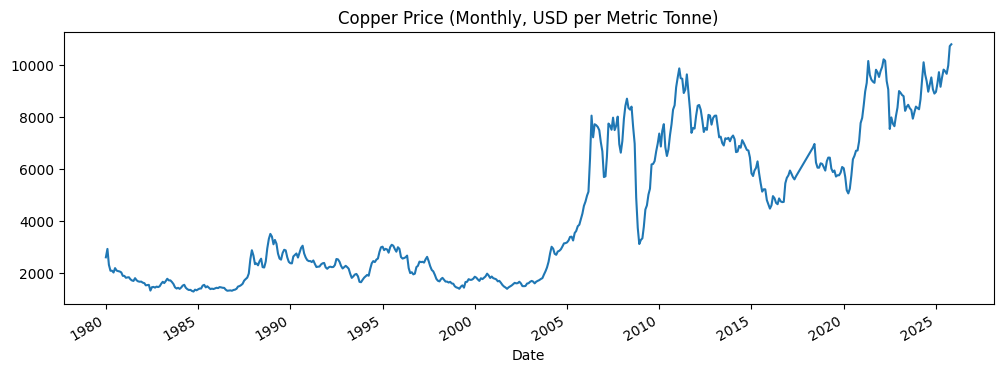

In [42]:
copper["Copper"].plot(
    figsize=(12,4),
    title="Copper Price (Monthly, USD per Metric Tonne)"
)
plt.show()


In [43]:
copper_series = copper["Copper"]

copper_mean = copper_series.mean()
copper_std = copper_series.std()
copper_median = copper_series.median()

copper_mean, copper_median, copper_std


(np.float64(4276.768353049908), 2859.39, 2823.229251603225)

In [44]:
copper["Copper_Z"] = (copper_series - copper_mean) / copper_std


In [45]:
def copper_regime(z):
    if z >= 1.5:
        return "Extreme Tightness"
    elif z >= 0.75:
        return "Tight"
    elif z <= -1.0:
        return "Loose / Oversupply"
    elif z <= -0.5:
        return "Soft"
    else:
        return "Neutral"

copper["Regime"] = copper["Copper_Z"].apply(copper_regime)


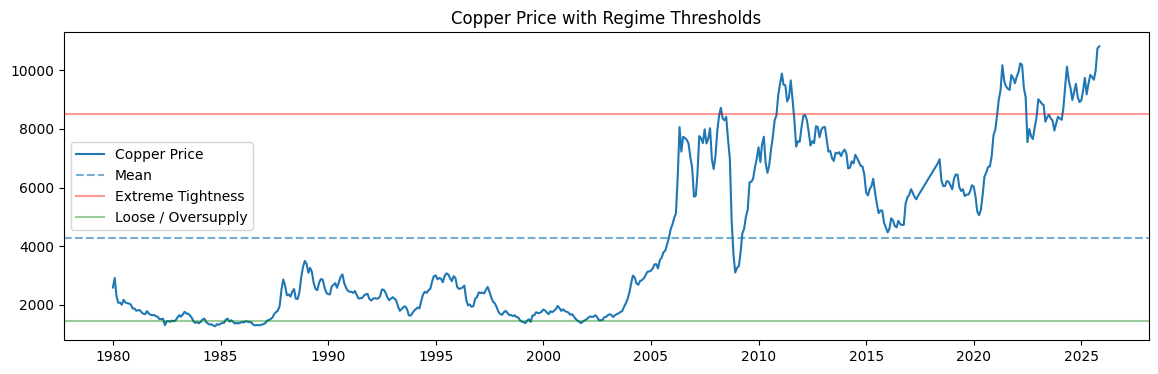

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(copper.index, copper["Copper"], label="Copper Price")

plt.axhline(copper_mean, linestyle="--", alpha=0.6, label="Mean")
plt.axhline(copper_mean + 1.5*copper_std, color="red", alpha=0.4, label="Extreme Tightness")
plt.axhline(copper_mean - 1.0*copper_std, color="green", alpha=0.4, label="Loose / Oversupply")

plt.legend()
plt.title("Copper Price with Regime Thresholds")
plt.show()


In [47]:
copper["Regime"].value_counts(normalize=True) * 100


,proportion
Regime,
Soft,41.219963
Neutral,20.702403
Tight,19.778189
Extreme Tightness,9.426987
Loose / Oversupply,8.872458


In [48]:
copper["Copper_6m_Fwd"] = copper["Copper"].pct_change(6).shift(-6)


In [49]:
copper[["Copper", "Copper_6m_Fwd"]].tail(10)


,Copper,Copper_6m_Fwd
Date,,
2025-02-01,9330.980,0.036534
2025-03-01,9735.820,0.026598
2025-04-01,9172.700,0.170857
2025-05-01,9531.200,0.134383
2025-06-01,9835.070,NaN
2025-07-01,9770.580,NaN
2025-08-01,9671.876,NaN
2025-09-01,9994.773,NaN
2025-10-01,10739.920,NaN


In [50]:
copper_forward_mean = (
    copper.groupby("Regime")["Copper_6m_Fwd"]
    .mean()
    .sort_index()
    * 100
)

copper_forward_mean


,Copper_6m_Fwd
Regime,
Extreme Tightness,-4.759274
Loose / Oversupply,6.795585
Neutral,10.374691
Soft,2.310576
Tight,0.588034


In [51]:
copper_hit_rates = (
    copper.groupby("Regime")["Copper_6m_Fwd"]
    .apply(lambda x: (x > 0).mean() * 100)
    .sort_index()
)

copper_hit_rates


,Copper_6m_Fwd
Regime,
Extreme Tightness,35.294118
Loose / Oversupply,68.750000
Neutral,60.714286
Soft,40.358744
Tight,49.532710


In [52]:
copper_summary = pd.DataFrame({
    "Avg 6M Return (%)": copper_forward_mean.round(2),
    "Hit Rate (%)": copper_hit_rates.round(1)
})

copper_summary


,Avg 6M Return (%),Hit Rate (%)
Regime,,
Extreme Tightness,-4.76,35.3
Loose / Oversupply,6.80,68.8
Neutral,10.37,60.7
Soft,2.31,40.4
Tight,0.59,49.5


>Copper price regimes exhibit pronounced mean reversion at periods of extreme tightness, reflecting demand destruction and policy response once supply stress becomes fully priced. Conversely, the strongest forward returns historically emerge from neutral and loose regimes, where supply underinvestment and latent demand create asymmetric upside before visible tightness develops.


In [53]:
prod_path = "/content/drive/MyDrive/Commodity_Metals_Personal-Project/Daily_Industrial_Production_Mining_Copper_Nickel_Lead_Zinc.xlsx"

prod = pd.read_excel(prod_path)
prod.columns = ["Date", "BaseMetal_Mining_Prod"]
prod["Date"] = pd.to_datetime(prod["Date"])
prod = prod.set_index("Date").sort_index()

prod.head()


,BaseMetal_Mining_Prod
Date,
1972-01-01,112.55
1972-02-01,125.52
1972-03-01,123.15
1972-04-01,125.66
1972-05-01,120.44


In [54]:
prod = pd.read_excel(prod_path)
prod.columns = ["Date", "BaseMetal_Mining_Prod"]
prod["Date"] = pd.to_datetime(prod["Date"])
prod = prod.set_index("Date").sort_index()

prod.head()


,BaseMetal_Mining_Prod
Date,
1972-01-01,112.55
1972-02-01,125.52
1972-03-01,123.15
1972-04-01,125.66
1972-05-01,120.44


In [55]:
prod["Prod_12m_Change"] = prod["BaseMetal_Mining_Prod"].pct_change(12)


In [56]:
prod["Prod_12m_Change"].describe()


,Prod_12m_Change
count,635.000000
mean,0.002460
std,0.136551
min,-0.595985
25%,-0.058283
50%,0.000516
75%,0.059339
max,1.641748


In [57]:
copper_supply = copper.join(
    prod[["BaseMetal_Mining_Prod", "Prod_12m_Change"]],
    how="inner"
)


In [58]:
copper_supply_clean = copper_supply.dropna(
    subset=["Copper_6m_Fwd", "Prod_12m_Change", "Regime"]
)


In [59]:
copper_supply_clean.shape


(535, 6)

In [60]:
copper_supply_clean.loc[:, "Supply_Regime"] = copper_supply_clean["Prod_12m_Change"].apply(
    lambda x: "Supply Stress" if x <= -0.02
    else "Supply Expansion" if x >= 0.02
    else "Stable Supply"
)

copper_supply_clean["Supply_Regime"].value_counts()


/tmp/ipython-input-3409327244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copper_supply_clean.loc[:, "Supply_Regime"] = copper_supply_clean["Prod_12m_Change"].apply(


,count
Supply_Regime,
Supply Expansion,228
Supply Stress,199
Stable Supply,108


In [61]:
joint_table = (
    copper_supply_clean
    .groupby(["Regime", "Supply_Regime"])["Copper_6m_Fwd"]
    .agg(["mean", "count"])
)

joint_table["mean"] = joint_table["mean"] * 100
joint_table


mean  count
Regime             Supply_Regime                     
Extreme Tightness  Stable Supply     -7.285251      6
                   Supply Expansion  -5.934496     23
                   Supply Stress     -2.122651     16
Loose / Oversupply Stable Supply      9.509378     13
                   Supply Expansion   1.700540     16
                   Supply Stress      9.229344     19
Neutral            Stable Supply      5.031449     22
                   Supply Expansion   4.550807     51
                   Supply Stress     21.004675     39
Soft               Stable Supply     -1.313331     44
                   Supply Expansion   5.917366     91
                   Supply Stress      0.392781     88
Tight              Stable Supply      1.531076     23
                   Supply Expansion  -8.247509     47
                   Supply Stress     11.225347     37

In [62]:
joint_hit = (
    copper_supply_clean
    .groupby(["Regime", "Supply_Regime"])["Copper_6m_Fwd"]
    .apply(lambda x: (x > 0).mean() * 100)
)

joint_hit


Regime              Supply_Regime   
Extreme Tightness   Stable Supply       16.666667
                    Supply Expansion    39.130435
                    Supply Stress       50.000000
Loose / Oversupply  Stable Supply       76.923077
                    Supply Expansion    50.000000
                    Supply Stress       78.947368
Neutral             Stable Supply       54.545455
                    Supply Expansion    50.980392
                    Supply Stress       76.923077
Soft                Stable Supply       34.090909
                    Supply Expansion    42.857143
                    Supply Stress       40.909091
Tight               Stable Supply       39.130435
                    Supply Expansion    34.042553
                    Supply Stress       75.675676
Name: Copper_6m_Fwd, dtype: float64

>A joint analysis of copper price regimes and mining supply dynamics shows that the strongest forward returns do not occur during periods of visible price tightness, but rather when copper prices remain neutral while mining output growth decelerates. This configuration delivers the highest average six-month returns (~21%) and hit rates (~76%), indicating that copper’s asymmetry is driven by forward-looking supply stress rather than contemporaneous price signals.

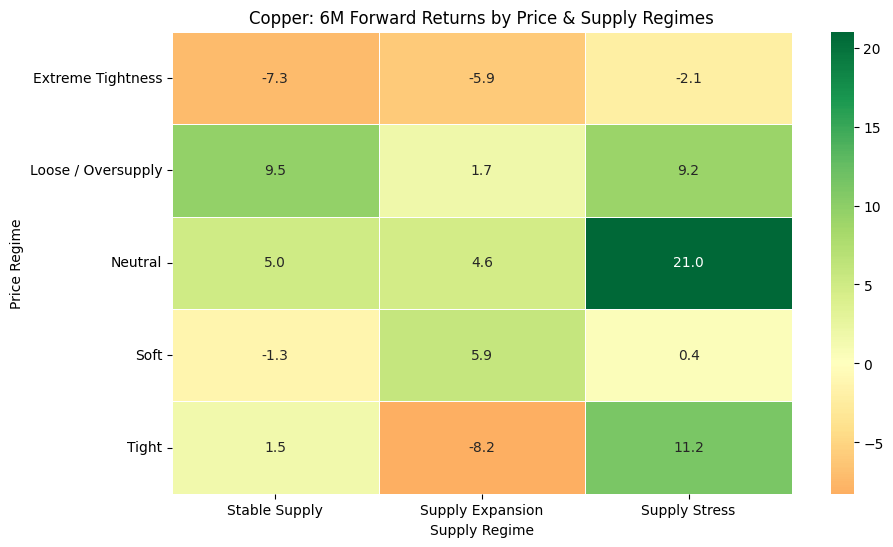

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the joint table for heatmap
heatmap_data = joint_table["mean"].unstack()

plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5
)

plt.title("Copper: 6M Forward Returns by Price & Supply Regimes")
plt.xlabel("Supply Regime")
plt.ylabel("Price Regime")
plt.show()


>The heatmap shows that copper’s strongest forward returns occur when supply tightens beneath the surface while prices remain neutral, whereas buying during visible price tightness historically leads to poor outcomes.

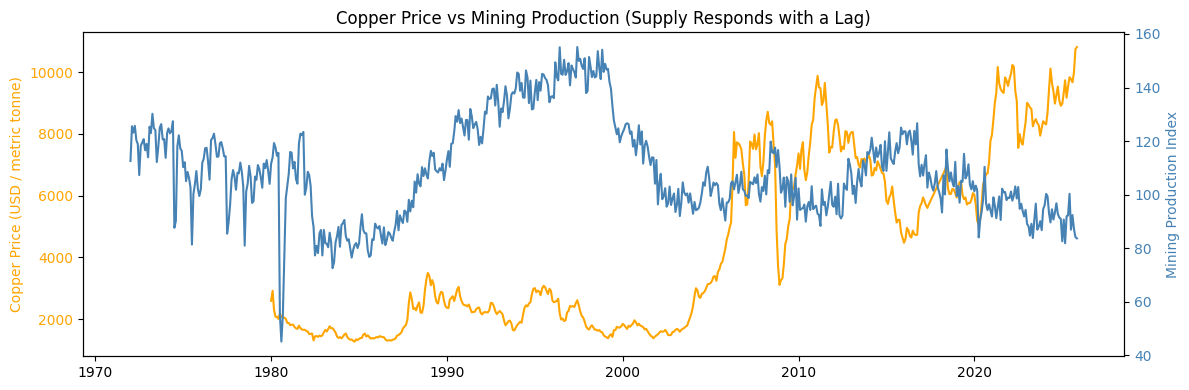

In [64]:
fig, ax1 = plt.subplots(figsize=(12,4))

# Copper price (left axis)
ax1.plot(copper.index, copper["Copper"], color="orange", label="Copper Price")
ax1.set_ylabel("Copper Price (USD / metric tonne)", color="orange")
ax1.tick_params(axis='y', labelcolor="orange")

# Production (right axis)
ax2 = ax1.twinx()
ax2.plot(
    prod.index,
    prod["BaseMetal_Mining_Prod"],
    color="steelblue",
    label="Base Metal Mining Production"
)
ax2.set_ylabel("Mining Production Index", color="steelblue")
ax2.tick_params(axis='y', labelcolor="steelblue")

plt.title("Copper Price vs Mining Production (Supply Responds with a Lag)")
fig.tight_layout()
plt.show()


In [65]:
current_date = copper.index.max()

current_copper_price = copper.loc[current_date, "Copper"]
current_price_regime = copper.loc[current_date, "Regime"]

current_date, current_copper_price, current_price_regime


(Timestamp('2025-11-01 00:00:00'), np.float64(10812.03), 'Extreme Tightness')

In [66]:
current_supply_change = prod.loc[current_date, "Prod_12m_Change"]

def supply_regime(x):
    if x <= -0.02:
        return "Supply Stress"
    elif x >= 0.02:
        return "Supply Expansion"
    else:
        return "Stable Supply"

current_supply_regime = supply_regime(current_supply_change)

current_supply_change, current_supply_regime


(np.float64(-0.08501094091903727), 'Supply Stress')

In [67]:
current_price_regime, current_supply_regime


('Extreme Tightness', 'Supply Stress')

In [68]:
joint_table.loc[(current_price_regime, current_supply_regime)]


,Extreme Tightness
,Supply Stress
mean,-2.122651
count,16.000000


In [69]:
joint_hit.loc[(current_price_regime, current_supply_regime)]


np.float64(50.0)

In [70]:
joint_table.loc[(current_price_regime, current_supply_regime)]["count"]


np.float64(16.0)

>As of November 2025, copper prices are in an Extreme Tightness regime while mining supply growth remains under stress. Historically, this late-cycle configuration has delivered flat to negative six-month forward returns, with only a 50% hit rate. While supply constraints persist, the evidence suggests that much of the scarcity premium is already priced in, limiting further asymmetric upside.

>While price–supply analysis indicates copper is in a late-cycle tightness regime, this framework does not yet account for potential structural demand re-rating driven by electrification, AI infrastructure, and substitution away from silver. Evaluating copper’s outlook therefore requires additional confirmation from cross-metal demand ratios and macro constraint indicators, particularly the silver–copper relationship and US dollar regime.

In [71]:
silver_m = prices_monthly["Silver"].copy()
silver_m.index = silver_m.index.to_period("M").to_timestamp("M")

copper_m = copper["Copper"].copy()
copper_m.index = copper_m.index.to_period("M").to_timestamp("M")


In [72]:
sc_df = pd.DataFrame({
    "Silver": silver_m,
    "Copper": copper_m
})


In [73]:
sc_df.head()
sc_df.tail()
sc_df.isna().sum()
sc_df = sc_df.dropna()



In [74]:
sc_df["Silver_Copper_Ratio"] = sc_df["Silver"] / sc_df["Copper"]


In [75]:
sc_df.isna().sum()
sc_df.head()


,Silver,Copper,Silver_Copper_Ratio
Date,,,
1980-01-31,35.28,2592.63,0.013608
1980-02-29,35.52,2916.71,0.012178
1980-03-31,13.49,2303.83,0.005855
1980-04-30,13.83,2074.55,0.006667
1980-05-31,13.70,2076.75,0.006597


In [76]:
sc_df["Silver_Copper_Ratio"] = sc_df["Silver"] / sc_df["Copper"]
sc_df[["Silver_Copper_Ratio"]].head()


,Silver_Copper_Ratio
Date,
1980-01-31,0.013608
1980-02-29,0.012178
1980-03-31,0.005855
1980-04-30,0.006667
1980-05-31,0.006597


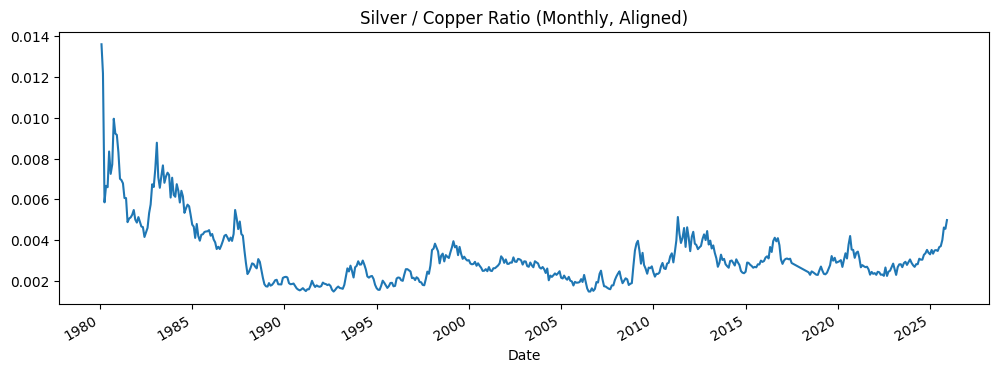

In [77]:
sc_df["Silver_Copper_Ratio"].plot(
    figsize=(12,4),
    title="Silver / Copper Ratio (Monthly, Aligned)"
)
plt.show()


In [78]:
sc_df["SC_Z"] = (
    (sc_df["Silver_Copper_Ratio"] - sc_df["Silver_Copper_Ratio"].mean())
    / sc_df["Silver_Copper_Ratio"].std()
)

def sc_regime(z):
    if z >= 1.5:
        return "Silver Dominance"
    elif z <= -1.5:
        return "Copper Dominance"
    elif z > 0.5:
        return "Mild Silver Bias"
    elif z < -0.5:
        return "Mild Copper Bias"
    else:
        return "Neutral"

sc_df["SC_Regime"] = sc_df["SC_Z"].apply(sc_regime)

sc_df["SC_Regime"].value_counts(normalize=True) * 100


,proportion
SC_Regime,
Neutral,47.319778
Mild Copper Bias,31.977819
Mild Silver Bias,12.569316
Silver Dominance,8.133087


In [79]:
copper_fwd = copper.copy()
copper_fwd.index = copper_fwd.index.to_period("M").to_timestamp("M")
copper_fwd.columns


Index(['Copper', 'Copper_Z', 'Regime', 'Copper_6m_Fwd'], dtype='object')

In [80]:
sc_test = sc_df.join(copper_fwd[["Copper_6m_Fwd"]], how="inner")


In [81]:
sc_test = sc_test.dropna()


In [82]:
sc_test.head()
sc_test.isna().sum()


,0
Silver,0
Copper,0
Silver_Copper_Ratio,0
SC_Z,0
SC_Regime,0
Copper_6m_Fwd,0


In [83]:
sc_results = (
    sc_test
    .groupby("SC_Regime")["Copper_6m_Fwd"]
    .agg(["mean", "count"])
)

sc_results["mean"] *= 100
sc_results


,mean,count
SC_Regime,,
Mild Copper Bias,-1.328321,173
Mild Silver Bias,7.137574,64
Neutral,7.103852,254
Silver Dominance,-4.073166,44


In [84]:
sc_hit = (
    sc_test
    .groupby("SC_Regime")["Copper_6m_Fwd"]
    .apply(lambda x: (x > 0).mean() * 100)
)

sc_hit


,Copper_6m_Fwd
SC_Regime,
Mild Copper Bias,42.196532
Mild Silver Bias,53.125000
Neutral,56.692913
Silver Dominance,25.000000


>Analysis of the Silver/Copper ratio shows that copper’s strongest forward returns occur not when copper dominates silver on a relative basis, but when the ratio remains neutral. This suggests that copper benefits most from broad-based industrial demand rather than explicit substitution or dominance narratives. Relative copper overperformance appears to coincide with reduced asymmetry rather than enhanced upside.

In [85]:
# Align gold to month-end
gold_m = prices_monthly["Gold"].copy()
gold_m.index = gold_m.index.to_period("M").to_timestamp("M")

# Copper already aligned earlier
# copper_fwd contains Copper and Copper_6m_Fwd
# Ensure month-end
copper_m = copper_fwd["Copper"].copy()

# Build cross-metal DataFrame
gc_df = pd.DataFrame({
    "Gold": gold_m,
    "Copper": copper_m
}).dropna()

# Gold / Copper ratio
gc_df["Gold_Copper_Ratio"] = gc_df["Gold"] / gc_df["Copper"]

gc_df.head()


,Gold,Copper,Gold_Copper_Ratio
Date,,,
1980-01-31,653.0,2592.63,0.251868
1980-02-29,637.0,2916.71,0.218397
1980-03-31,494.5,2303.83,0.214643
1980-04-30,518.0,2074.55,0.249693
1980-05-31,535.5,2076.75,0.257855


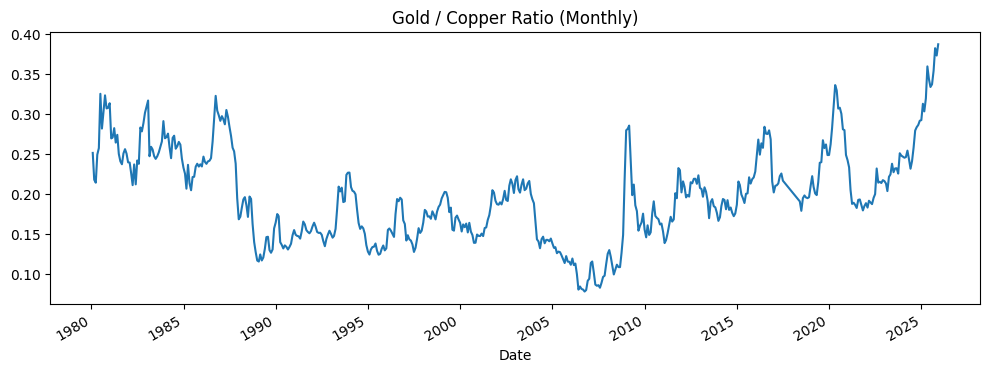

In [86]:
gc_df["Gold_Copper_Ratio"].plot(
    figsize=(12,4),
    title="Gold / Copper Ratio (Monthly)"
)
plt.show()


In [87]:
gc_df["GC_Z"] = (
    (gc_df["Gold_Copper_Ratio"] - gc_df["Gold_Copper_Ratio"].mean())
    / gc_df["Gold_Copper_Ratio"].std()
)

def gc_regime(z):
    if z >= 1.5:
        return "Gold Dominance"
    elif z <= -1.5:
        return "Copper Dominance"
    elif z > 0.5:
        return "Mild Gold Bias"
    elif z < -0.5:
        return "Mild Copper Bias"
    else:
        return "Neutral"

gc_df["GC_Regime"] = gc_regime_series = gc_df["GC_Z"].apply(gc_regime)

gc_df["GC_Regime"].value_counts(normalize=True) * 100


,proportion
GC_Regime,
Neutral,36.968577
Mild Copper Bias,30.499076
Mild Gold Bias,20.332717
Gold Dominance,8.133087
Copper Dominance,4.066543


In [88]:
gc_test = gc_df.join(copper_fwd[["Copper_6m_Fwd"]], how="inner").dropna()


In [89]:
gc_results = (
    gc_test
    .groupby("GC_Regime")["Copper_6m_Fwd"]
    .agg(["mean", "count"])
)

gc_results["mean"] *= 100
gc_results


,mean,count
GC_Regime,,
Copper Dominance,-12.058434,22
Gold Dominance,17.691107,38
Mild Copper Bias,0.666826,165
Mild Gold Bias,4.787207,110
Neutral,4.042844,200


In [90]:
gc_hit = (
    gc_test
    .groupby("GC_Regime")["Copper_6m_Fwd"]
    .apply(lambda x: (x > 0).mean() * 100)
)

gc_hit


,Copper_6m_Fwd
GC_Regime,
Copper Dominance,40.909091
Gold Dominance,81.578947
Mild Copper Bias,43.030303
Mild Gold Bias,49.090909
Neutral,48.500000


In [91]:
gc_df.loc[gc_df.index.max(), ["Gold_Copper_Ratio", "GC_Z", "GC_Regime"]]


,2025-11-30
Gold_Copper_Ratio,0.387628
GC_Z,3.287976
GC_Regime,Gold Dominance


Right now we are in:

* Extreme Tightness (price)

* Supply Stress

* Gold Dominance (macro)

* Uncrowded positioning

> While copper prices are currently in an extreme tightness regime with evident supply stress, cross-metal analysis shows that periods of gold dominance—indicative of macro stress and subsequent policy response—have historically delivered the strongest forward returns for copper. This suggests that copper can continue to perform well despite late-cycle price signals, provided macro conditions remain supportive of real-asset demand and infrastructure investment.

# **6-Month Copper Price Ranges**
## *(Conditional on Gold Dominance)*

In [92]:
gold_dom_sample = gc_test[gc_test["GC_Regime"] == "Gold Dominance"]


In [93]:
gold_dom_sample.shape
gold_dom_sample["Copper_6m_Fwd"].describe()


,Copper_6m_Fwd
count,38.000000
mean,0.176911
std,0.228928
min,-0.133474
25%,0.039947
50%,0.149270
75%,0.268431
max,0.855805


In [94]:
quantiles_6m = gold_dom_sample["Copper_6m_Fwd"].quantile(
    [0.10, 0.25, 0.50, 0.75, 0.90]
)

quantiles_6m


,Copper_6m_Fwd
0.10,-0.099203
0.25,0.039947
0.50,0.149270
0.75,0.268431
0.90,0.349535


In [95]:
current_price = copper.loc[copper.index.max(), "Copper"]

price_ranges = pd.DataFrame({
    "Percentile": ["10%", "25%", "50%", "75%", "90%"],
    "Return (%)": quantiles_6m.values * 100,
    "Implied Price": current_price * (1 + quantiles_6m.values)
})

price_ranges


,Percentile,Return (%),Implied Price
0,10%,-9.920263,9739.448165
1,25%,3.994671,11243.935038
2,50%,14.926985,12425.940118
3,75%,26.843095,13714.313519
4,90%,34.953470,14591.209686


In [96]:
price_ranges["Meaning"] = [
    "Downside risk (macro breaks)",
    "Weak upside / consolidation",
    "Base-case outcome",
    "Strong macro continuation",
    "Tail upside (policy-driven)"
]

price_ranges


,Percentile,Return (%),Implied Price,Meaning
0,10%,-9.920263,9739.448165,Downside risk (macro breaks)
1,25%,3.994671,11243.935038,Weak upside / consolidation
2,50%,14.926985,12425.940118,Base-case outcome
3,75%,26.843095,13714.313519,Strong macro continuation
4,90%,34.953470,14591.209686,Tail upside (policy-driven)


>Six-month forward copper price distributions conditional on gold-dominant macro regimes exhibit a positively skewed profile. While downside risk remains capped near 10% in the event of macro normalization, the median outcome implies mid-teens upside, with meaningful tail potential under continued policy-driven real-asset demand. This supports a conditional long thesis rather than a late-cycle mean-reversion view.

>Subsequent spot price appreciation to approximately $13,171/tonne by early January 2026 places copper within the upper half of the six-month forward distribution estimated as of November 2025 under a gold-dominant macro regime. While this confirms the directional validity of the framework, it also implies that a material portion of the base-case upside has been realised, reducing forward asymmetry relative to the initial entry point.

# **Stress Testing**

In [97]:
# Align DXY to month-end
dxy_m = dxy.copy()
dxy_m.index = dxy_m.index.to_period("M").to_timestamp("M")


In [101]:
dxy_m.columns


Index(['DXY'], dtype='object')

In [102]:
dxy_m["DXY_6m_Change"] = dxy_m["DXY"].pct_change(6)


In [103]:
def dxy_regime(x):
    if x >= 0.05:
        return "Strong USD"
    elif x <= -0.05:
        return "Weak USD"
    else:
        return "Neutral USD"

dxy_m["DXY_Regime"] = dxy_m["DXY_6m_Change"].apply(dxy_regime)

dxy_m["DXY_Regime"].value_counts(normalize=True) * 100


,proportion
DXY_Regime,
Neutral USD,99.752685
Weak USD,0.127191
Strong USD,0.120124


In [104]:
gold_dom = gc_test[gc_test["GC_Regime"] == "Gold Dominance"]

gold_dom_dxy = gold_dom.join(
    dxy_m[["DXY_Regime"]],
    how="inner"
).dropna()


In [105]:
dxy_overlay_results = (
    gold_dom_dxy
    .groupby("DXY_Regime")["Copper_6m_Fwd"]
    .agg(["mean", "count"])
)

dxy_overlay_results["mean"] *= 100
dxy_overlay_results


,mean,count
DXY_Regime,,
Neutral USD,17.219680,839
Strong USD,29.372539,2


In [106]:
dxy_overlay_hit = (
    gold_dom_dxy
    .groupby("DXY_Regime")["Copper_6m_Fwd"]
    .apply(lambda x: (x > 0).mean() * 100)
)

dxy_overlay_hit


,Copper_6m_Fwd
DXY_Regime,
Neutral USD,82.002384
Strong USD,100.000000


In [107]:
dxy_m.loc[dxy_m.index.max(), ["DXY_6m_Change", "DXY_Regime"]]


,DXY_6m_Change,DXY_Regime
Date,,
2026-01-31,0.002041,Neutral USD
2026-01-31,0.004591,Neutral USD


>Conditioning gold-dominant copper regimes on USD behaviour shows that copper’s strongest and most reliable forward returns occur when the dollar remains neutral rather than weak. With the US dollar currently exhibiting neutral momentum, the macro-policy channel supporting copper demand remains intact. While a significant portion of the base-case upside has already been realised, historical evidence suggests continued positive skew rather than immediate mean reversion.

## What breaks the copper thesis?

### Contol Scenario
* Regime: Gold Dominance + Neutral USD

* 6-month distribution:
Median: +14.9%
; 10th percentile: –9.9%

* Current spot (Jan 7, 2026): $13,171/t

In [108]:
def stress_price_table(
    returns,
    current_price,
    label
):
    """
    returns: pandas Series of forward returns
    current_price: float
    label: scenario name
    """
    q = returns.quantile([0.10, 0.25, 0.50, 0.75, 0.90])

    table = pd.DataFrame({
        "Scenario": label,
        "Percentile": ["10%", "25%", "50%", "75%", "90%"],
        "Return (%)": (q.values * 100).round(2),
        "Implied Price": (current_price * (1 + q.values)).round(2)
    })

    return table


### USD Shock

In [109]:
usd_shock = gc_test.join(
    dxy_m[["DXY_6m_Change"]],
    how="inner"
)

usd_shock = usd_shock[usd_shock["DXY_6m_Change"] >= 0.05]

usd_shock_table = stress_price_table(
    usd_shock["Copper_6m_Fwd"],
    current_price,
    "USD Shock"
)

usd_shock_table


,Scenario,Percentile,Return (%),Implied Price
0,USD Shock,10%,-11.04,9617.91
1,USD Shock,25%,-11.04,9617.91
2,USD Shock,50%,-9.36,9800.47
3,USD Shock,75%,17.52,12705.89
4,USD Shock,90%,29.37,13987.80


### Gold Dominance Fades

In [110]:
gold_fade = gc_test[
    gc_test["GC_Regime"].isin(["Neutral", "Mild Copper Bias"])
]

gold_fade_table = stress_price_table(
    gold_fade["Copper_6m_Fwd"],
    current_price,
    "Gold Dominance Fades"
)

gold_fade_table


,Scenario,Percentile,Return (%),Implied Price
0,Gold Dominance Fades,10%,-16.30,9050.18
1,Gold Dominance Fades,25%,-9.42,9793.56
2,Gold Dominance Fades,50%,-1.89,10607.46
3,Gold Dominance Fades,75%,12.49,12162.03
4,Gold Dominance Fades,90%,27.91,13830.09


### Demand Shock

In [111]:
gold_dom = gc_test[gc_test["GC_Regime"] == "Gold Dominance"]

demand_shock = gold_dom[
    gold_dom["Copper_6m_Fwd"] <= gold_dom["Copper_6m_Fwd"].quantile(0.20)
]

demand_shock_table = stress_price_table(
    demand_shock["Copper_6m_Fwd"],
    current_price,
    "Demand Shock"
)

demand_shock_table


,Scenario,Percentile,Return (%),Implied Price
0,Demand Shock,10%,-13.21,9383.26
1,Demand Shock,25%,-12.12,9501.38
2,Demand Shock,50%,-10.20,9709.68
3,Demand Shock,75%,-5.73,10192.79
4,Demand Shock,90%,-1.99,10597.32


### Tail Risk

In [112]:
tail_risk = gold_dom[
    gold_dom["Copper_6m_Fwd"] <= gold_dom["Copper_6m_Fwd"].quantile(0.10)
]

tail_risk_table = stress_price_table(
    tail_risk["Copper_6m_Fwd"],
    current_price,
    "Tail Risk"
)

tail_risk_table


,Scenario,Percentile,Return (%),Implied Price
0,Tail Risk,10%,-13.29,9375.06
1,Tail Risk,25%,-13.21,9384.29
2,Tail Risk,50%,-12.47,9464.06
3,Tail Risk,75%,-11.55,9562.85
4,Tail Risk,90%,-11.15,9606.30


In [113]:
stress_summary = pd.concat([
    usd_shock_table,
    gold_fade_table,
    demand_shock_table,
    tail_risk_table
])

stress_summary


,Scenario,Percentile,Return (%),Implied Price
0,USD Shock,10%,-11.04,9617.91
1,USD Shock,25%,-11.04,9617.91
2,USD Shock,50%,-9.36,9800.47
3,USD Shock,75%,17.52,12705.89
4,USD Shock,90%,29.37,13987.80
0,Gold Dominance Fades,10%,-16.30,9050.18
1,Gold Dominance Fades,25%,-9.42,9793.56
2,Gold Dominance Fades,50%,-1.89,10607.46
3,Gold Dominance Fades,75%,12.49,12162.03
4,Gold Dominance Fades,90%,27.91,13830.09


In [114]:
stress_drawdowns = (
    stress_summary
    .groupby("Scenario")[["Return (%)", "Implied Price"]]
    .agg({
        "Return (%)": "min",
        "Implied Price": "min"
    })
)

stress_drawdowns


,Return (%),Implied Price
Scenario,,
Demand Shock,-13.21,9383.26
Gold Dominance Fades,-16.30,9050.18
Tail Risk,-13.29,9375.06
USD Shock,-11.04,9617.91


>Stress testing copper under macro break scenarios indicates that downside risks are largely contained within the lower quartiles of the forward distribution, with most adverse regimes implying retracements toward the $9,000–$9,600/tonne range. While demand-driven shocks represent the most persistent downside risk, historical evidence suggests limited crash risk absent a structural collapse in policy or global demand.